## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [6]:
!pip install tensorflow
!pip install dill
!pip install xgboost
!pip install lightgbm



In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [3]:
import pandas as pd

# Hardcoding the file names
file_names = [
    'flights_cleaned.csv'
]

# Reading each file into a DataFrame
dataframes = [pd.read_csv(file_name) for file_name in file_names]

# Combining all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY_NEW
0,3,8,1,1,AA,JFK,BOS,2135,0.0
1,3,8,1,1,AA,JFK,LAX,730,0.0
2,3,8,1,1,AA,JFK,LAX,1845,16.0
3,3,8,1,1,AA,JFK,LAX,1130,0.0
4,3,8,1,1,AA,JFK,LAX,1030,0.0
...,...,...,...,...,...,...,...,...,...
310726,3,8,31,4,WN,LGA,TPA,1820,0.0
310727,3,8,31,4,WN,LGA,STL,1525,3.0
310728,3,8,31,4,WN,LGA,BNA,1855,9.0
310729,3,8,31,4,WN,LGA,ATL,1055,18.0


#### Show Top 5 Records

#### Preparing X and Y variables

In [4]:
# Set negative values to zero
combined_df['DEP_DELAY_NEW'] = combined_df['DEP_DELAY_NEW'].apply(lambda x: 0 if x < 0 else x)

# Remove rows where the value is greater than 180
combined_df = combined_df[combined_df['DEP_DELAY_NEW'] <= 180]

# Filter the rows where ORIGIN is one of 'JFK', 'EWR', 'LGA', 'HPN'
filtered_combined_df = combined_df[combined_df['ORIGIN'].isin(['JFK', 'EWR', 'LGA', 'HPN'])]

combined_df.to_csv('flights_cleaned.csv', index=False)

# Update the original DataFrame
X = filtered_combined_df.copy()

In [5]:
X.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY_NEW
0,3,8,1,1,AA,JFK,BOS,2135,0.0
1,3,8,1,1,AA,JFK,LAX,730,0.0
2,3,8,1,1,AA,JFK,LAX,1845,16.0
3,3,8,1,1,AA,JFK,LAX,1130,0.0
4,3,8,1,1,AA,JFK,LAX,1030,0.0


In [6]:
categorical_columns = ["QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", 
                                   "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_CITY_NAME", 
                                   "DEST", "DEST_CITY_NAME"]

print("Categories in 'QUARTER' variable: ", end=" ")
print(combined_df['QUARTER'].unique())

print("Categories in 'MONTH' variable: ", end=" ")
print(combined_df['MONTH'].unique())

print("Categories in 'DAY_OF_MONTH' variable: ", end=" ")
print(combined_df['DAY_OF_MONTH'].unique())

print("Categories in 'DAY_OF_WEEK' variable: ", end=" ")
print(combined_df['DAY_OF_WEEK'].unique())

print("Categories in 'OP_UNIQUE_CARRIER' variable: ", end=" ")
print(combined_df['OP_UNIQUE_CARRIER'].unique())

print("Categories in 'ORIGIN' variable: ", end=" ")
print(combined_df['ORIGIN'].unique())

print("Categories in 'DEST' variable: ", end=" ")
print(combined_df['DEST'].unique())

Categories in 'QUARTER' variable:  [3 4 2 1]
Categories in 'MONTH' variable:  [ 8  9 10 11 12  5  2  3  4  6  7]
Categories in 'DAY_OF_MONTH' variable:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Categories in 'DAY_OF_WEEK' variable:  [1 2 3 4 5 6 7]
Categories in 'OP_UNIQUE_CARRIER' variable:  ['AA' 'OH' 'OO' 'YX' 'AS' 'B6' '9E' 'DL' 'F9' 'HA' 'NK' 'G7' 'UA' 'YV'
 'WN' 'MQ']
Categories in 'ORIGIN' variable:  ['JFK' 'LGA' 'HPN' 'EWR']
Categories in 'DEST' variable:  ['BOS' 'LAX' 'SFO' 'SNA' 'DCA' 'STL' 'DFW' 'MIA' 'PHX' 'ORD' 'AUS' 'CLT'
 'RDU' 'IAH' 'LAS' 'STT' 'FLL' 'IND' 'CMH' 'CLE' 'BNA' 'MEM' 'ORF' 'XNA'
 'PIT' 'ILM' 'SDF' 'CVG' 'MSP' 'RIC' 'GSO' 'OMA' 'DTW' 'ATL' 'CHO' 'BWI'
 'OKC' 'ORH' 'MCI' 'ROA' 'DAY' 'SEA' 'PDX' 'SAN' 'PWM' 'SAV' 'CHS' 'JAX'
 'PBI' 'MCO' 'ONT' 'SJU' 'BUR' 'RSW' 'ACK' 'HYA' 'SYR' 'BTV' 'BUF' 'ROC'
 'MKE' 'MVY' 'TPA' 'DEN' 'MSY' 'SLC' 'ABQ' 'SAT' 'BQN' 'RNO' 'SRQ' 'SJC'
 'SMF' 'MSN' 'IAD' 'ALB' 'GSP' 'BGR' '

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310731 entries, 0 to 310730
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   QUARTER            310731 non-null  int64  
 1   MONTH              310731 non-null  int64  
 2   DAY_OF_MONTH       310731 non-null  int64  
 3   DAY_OF_WEEK        310731 non-null  int64  
 4   OP_UNIQUE_CARRIER  310731 non-null  object 
 5   ORIGIN             310731 non-null  object 
 6   DEST               310731 non-null  object 
 7   CRS_DEP_TIME       310731 non-null  int64  
 8   DEP_DELAY_NEW      310731 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 21.3+ MB


In [8]:
X['QUARTER'] = X['QUARTER'].astype('object')
X['MONTH'] = X['MONTH'].astype('object')
X['DAY_OF_WEEK'] = X['DAY_OF_WEEK'].astype('object')
X['DAY_OF_MONTH'] = X['DAY_OF_MONTH'].astype('object')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310731 entries, 0 to 310730
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   QUARTER            310731 non-null  object 
 1   MONTH              310731 non-null  object 
 2   DAY_OF_MONTH       310731 non-null  object 
 3   DAY_OF_WEEK        310731 non-null  object 
 4   OP_UNIQUE_CARRIER  310731 non-null  object 
 5   ORIGIN             310731 non-null  object 
 6   DEST               310731 non-null  object 
 7   CRS_DEP_TIME       310731 non-null  int64  
 8   DEP_DELAY_NEW      310731 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [9]:
X = X.drop(columns=['DEP_DELAY_NEW'])
X

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME
0,3,8,1,1,AA,JFK,BOS,2135
1,3,8,1,1,AA,JFK,LAX,730
2,3,8,1,1,AA,JFK,LAX,1845
3,3,8,1,1,AA,JFK,LAX,1130
4,3,8,1,1,AA,JFK,LAX,1030
...,...,...,...,...,...,...,...,...
310726,3,8,31,4,WN,LGA,TPA,1820
310727,3,8,31,4,WN,LGA,STL,1525
310728,3,8,31,4,WN,LGA,BNA,1855
310729,3,8,31,4,WN,LGA,ATL,1055


In [10]:
y = combined_df['DEP_DELAY_NEW']

In [11]:
y.describe()

count    310731.000000
mean         12.596152
std          28.877869
min           0.000000
25%           0.000000
50%           0.000000
75%           9.000000
max         180.000000
Name: DEP_DELAY_NEW, dtype: float64

In [12]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [13]:
X = preprocessor.fit_transform(X)

In [14]:
X.shape

(310731, 185)

In [15]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((248584, 185), (62147, 185))

#### Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

In [22]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Define your evaluate_model function here
# def evaluate_model(true_values, predictions):
#    mae = mean_absolute_error(true_values, predictions)
#    rmse = np.sqrt(mean_squared_error(true_values, predictions))
#    return mae, rmse

# Assuming X_train, X_test, y_train, y_test are already defined
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor(),
    "LightGBM Regressor": LGBMRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    # Neural Network will be defined separately
}

model_list = []
mae_list = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae, model_train_rmse = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse = evaluate_model(y_test, y_test_pred)

    print(name)
    model_list.append(name)

    print('Model performance for Training set')
    print("- MAE: {:.4f}".format(model_train_mae))
    print("- RMSE: {:.4f}".format(model_train_rmse))

    print('Model performance for Test set')
    print("- MAE: {:.4f}".format(model_test_mae))
    print("- RMSE: {:.4f}".format(model_test_rmse))

    mae_list.append(model_test_mae)
    print('=' * 35)

# Determine the best model
best_model_name = min(zip(model_list, mae_list), key=lambda x: x[1])[0]
print(f"Best Model: {best_model_name}")

# Save the best performing model
best_model = models[best_model_name]
with open('model1.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Create and print the sorted DataFrame of model performance
mae_dataframe = pd.DataFrame(list(zip(model_list, mae_list)), columns=['Model Name', 'MAE']).sort_values(by="MAE", ascending=True)
print(mae_dataframe)


Linear Regression
Model performance for Training set
- MAE: 16.8046
- RMSE: 27.7701
Model performance for Test set
- MAE: 16.8572
- RMSE: 27.8381
Decision Tree
Model performance for Training set
- MAE: 0.0133
- RMSE: 0.7255
Model performance for Test set
- MAE: 16.6491
- RMSE: 35.1422
XGBRegressor
Model performance for Training set
- MAE: 14.9046
- RMSE: 25.3506
Model performance for Test set
- MAE: 15.3780
- RMSE: 26.3142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 248584, number of used features: 179
[LightGBM] [Info] Start training from score 12.606334


c:\Users\robjo\mlproject\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\robjo\mlproject\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LightGBM Regressor
Model performance for Training set
- MAE: 15.5357
- RMSE: 26.1706
Model performance for Test set
- MAE: 15.6180
- RMSE: 26.3801
Random Forest Regressor
Model performance for Training set
- MAE: 5.3550
- RMSE: 10.0733
Model performance for Test set
- MAE: 14.4602
- RMSE: 27.0084
Best Model: Random Forest Regressor
                Model Name        MAE
4  Random Forest Regressor  14.460186
2             XGBRegressor  15.378049
3       LightGBM Regressor  15.618008
1            Decision Tree  16.649074
0        Linear Regression  16.857178


### Results

In [17]:
import pandas as pd
import pickle
from sklearn.compose import ColumnTransformer

# Load the saved Scikit-learn model
with open('model1.pkl', 'rb') as file:
    model = pickle.load(file)

# Example new data with appropriate data types
new_data = pd.DataFrame({
    'QUARTER': [3],
    'MONTH': [8],
    'DAY_OF_MONTH': [6],
    'DAY_OF_WEEK': [6],
    'OP_UNIQUE_CARRIER': ['B6'],
    'ORIGIN': ['JFK'],
    'DEST': ['LAX'],
    'CRS_DEP_TIME': [1920]
})

# Convert data types to match training data
new_data['QUARTER'] = new_data['QUARTER'].astype('object')
new_data['MONTH'] = new_data['MONTH'].astype('object')
new_data['DAY_OF_WEEK'] = new_data['DAY_OF_WEEK'].astype('object')
new_data['DAY_OF_MONTH'] = new_data['DAY_OF_MONTH'].astype('object')
# Repeat for other columns as necessary

# Check for NaN values and handle them appropriately
# new_data = new_data.fillna(method='ffill')  # Example: forward fill

# Preprocess the new data using the same transformations as during training
# Assuming 'preprocessor' is already defined and loaded
prepared_data = preprocessor.transform(new_data)

# Make predictions
predicted_output = model.predict(prepared_data)
print(f"Predicted Output: {predicted_output[0]}")

Predicted Output: 130.5


In [17]:
import pandas as pd

# Assuming model_list and mae_list are already populated from the model evaluation loop
mae_dataframe = pd.DataFrame(list(zip(model_list, mae_list)), columns=['Model Name', 'MAE']).sort_values(by=["MAE"], ascending=True)

# Print the sorted DataFrame
print(mae_dataframe)


           Model Name        MAE
4      Neural Network  15.423576
2        XGBRegressor  15.546766
3  LightGBM Regressor  15.728111
0   Linear Regression  16.934628
1       Decision Tree  18.907695


## Linear Regression

In [18]:
from sklearn.metrics import mean_absolute_error

# Assuming nn_model is your trained neural network model
# Ensure X_test_dense is the preprocessed test set appropriate for the neural network

y_pred_nn = nn_model.predict(X_test_dense)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print("Mean Absolute Error of the neural network model is %.2f" % mae_nn)


1943/1943 [==============================] - 1s 523us/step
Mean Absolute Error of the neural network model is 15.42


## Plot y_pred and y_test

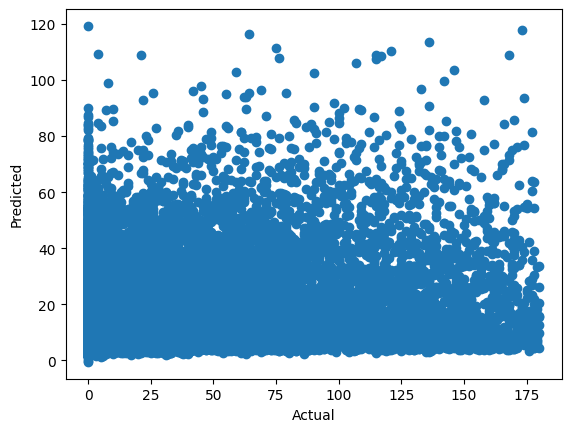

In [19]:
plt.scatter(y_test,y_pred_nn);
plt.xlabel('Actual');
plt.ylabel('Predicted');

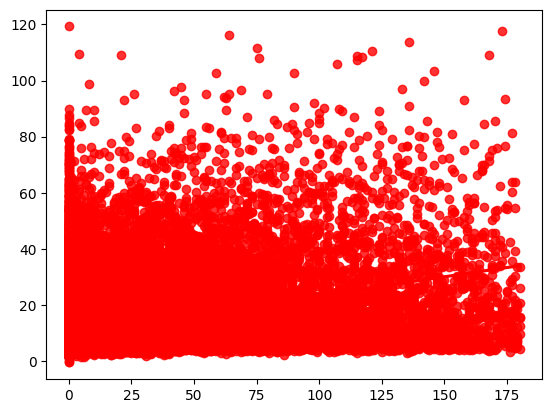

In [20]:
sns.regplot(x=y_test,y=y_pred_nn,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [21]:
# Flatten the predicted values to 1D if they are in 2D format
y_pred_nn_flat = y_pred_nn.flatten()

# Create a DataFrame with actual and predicted values
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred_nn_flat,
    'Difference': y_test - y_pred_nn_flat
})

print(pred_df)

       Actual Value  Predicted Value  Difference
0               0.0         4.932702   -4.932702
1               4.0        14.270229  -10.270229
2               0.0         8.088512   -8.088512
3               0.0         7.434288   -7.434288
4               0.0        12.241259  -12.241259
...             ...              ...         ...
62142           0.0        10.563841  -10.563841
62143           0.0         7.693949   -7.693949
62144          46.0        22.237930   23.762070
62145           0.0        15.196465  -15.196465
62146           0.0        24.675175  -24.675175

[62147 rows x 3 columns]
